In [652]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pl
import numpy as np

import numpy as np

#计算mape
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

#计算rmse
def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

#对于长宽等长的零向量，头尾均赋值tau等长的-1
def laplacian(T, tau):
    ell = np.zeros(T)
    ell[0] = 2 * tau
    for k in range(tau):
        ell[k + 1] = -1
        ell[-k - 1] = -1
    return ell

def prox_2d(z, w, lmbda, denominator):
    N, T = z.shape
    temp = np.fft.fft2(lmbda * z - w) / denominator
    temp1 = 1 - N * T / (lmbda * np.abs(temp))
    temp1[temp1 <= 0] = 0
    return np.fft.ifft2(temp * temp1).real

def update_z(y_train, pos_train, x, w, lmbda, eta):
    z = x + w / lmbda
    z[pos_train] = (lmbda / (lmbda + eta) * z[pos_train]
                    + eta / (lmbda + eta) * y_train)
    return z

def update_w(x, z, w, lmbda):
    return w + lmbda * (x - z)


def LCR_2d(y_true, y, lmbda, gamma, tau_s=1, tau=5, maxiter = 50):
    eta = 100 * lmbda
    N, T = y.shape
    pos_train = np.where(y != 0)
    print(y.shape)
    #挑选y中不等于0的值
    y_train = y[pos_train]
    #挑选y_true不等于0的值，但y等于0的值，测试集
    pos_test = np.where((y_true != 0) & (y == 0))
    y_test = y_true[pos_test]
    z = y.copy()
    w = y.copy()
    
    #N,T分别为长宽
    ell_s = laplacian(N, tau_s)
    ell_t = laplacian(T, tau)
    #np.outer计算外积，变成一个N*T的矩阵，np.fft.fft2（傅立叶变换）
    # print(np.fft.fft2(np.outer(ell_s, ell_t)) )
    denominator = lmbda + gamma * np.fft.fft2(np.outer(ell_s, ell_t)) ** 2
    
    del y_true, y
    show_iter = 20
    for it in range(maxiter):
        x = prox_2d(z, w, lmbda, denominator)
        z = update_z(y_train, pos_train, x, w, lmbda, eta)
        w = update_w(x, z, w, lmbda)
        if (it + 1) % show_iter == 0:
            print(it + 1)
            print("mape", compute_mape(y_test, x[pos_test]))
            print("rmse", compute_rmse(y_test, x[pos_test]))
            print()
    return x

#建立OD矩阵，传入模型计算结果
# mat_hat = LCR_2d(dense_mat, sparse_mat, lmbda, gamma, tau_s, tau, maxiter)


In [653]:
#读取数据
import numpy as np
np.random.seed(1000)
import scipy.io

dense_list=[]
tensorone = scipy.io.loadmat('tensor111.mat')
dense_one = tensorone['tensor']

# tensortwo = scipy.io.loadmat('tensor2.mat')
# dense_two = tensortwo['tensor']

dense_list.append(dense_one)
# dense_list.append(dense_two)
dense_tensor=np.array(dense_list)
dim =np.shape(dense_tensor)
missing_rate = 0.7

#对每一行乘一个偏置值
bais = np.round(np.random.rand(dim[0], dim[1])[:, :, np.newaxis] + 0.5 - missing_rate)

sparse_tensor = dense_tensor * bais
#维度变化，dim[0]为1
dense_mat = dense_tensor.reshape([dim[0]*dim[1] , dim[2]])
sparse_mat = sparse_tensor.reshape([dim[0]*dim[1] , dim[2]])


# del dense_tensor, sparse_tensor
dense_mat = dense_mat[80:287, 0:117] #取全部数据
sparse_mat = sparse_mat[80:287, 0:117]

(207, 117)
20
mape 1.2755301006657713
rmse 43.89124649317562

40
mape 0.8565908740673626
rmse 35.380656293126606

60
mape 0.7736899822577809
rmse 33.496425581787996

80
mape 0.7469374888482139
rmse 32.608393186632696

100
mape 0.7282791618861414
rmse 32.21312436191265

120
mape 0.7194290215407313
rmse 32.07162577482291

140
mape 0.7153413678579656
rmse 32.03036820498519

Running time: 0 seconds.


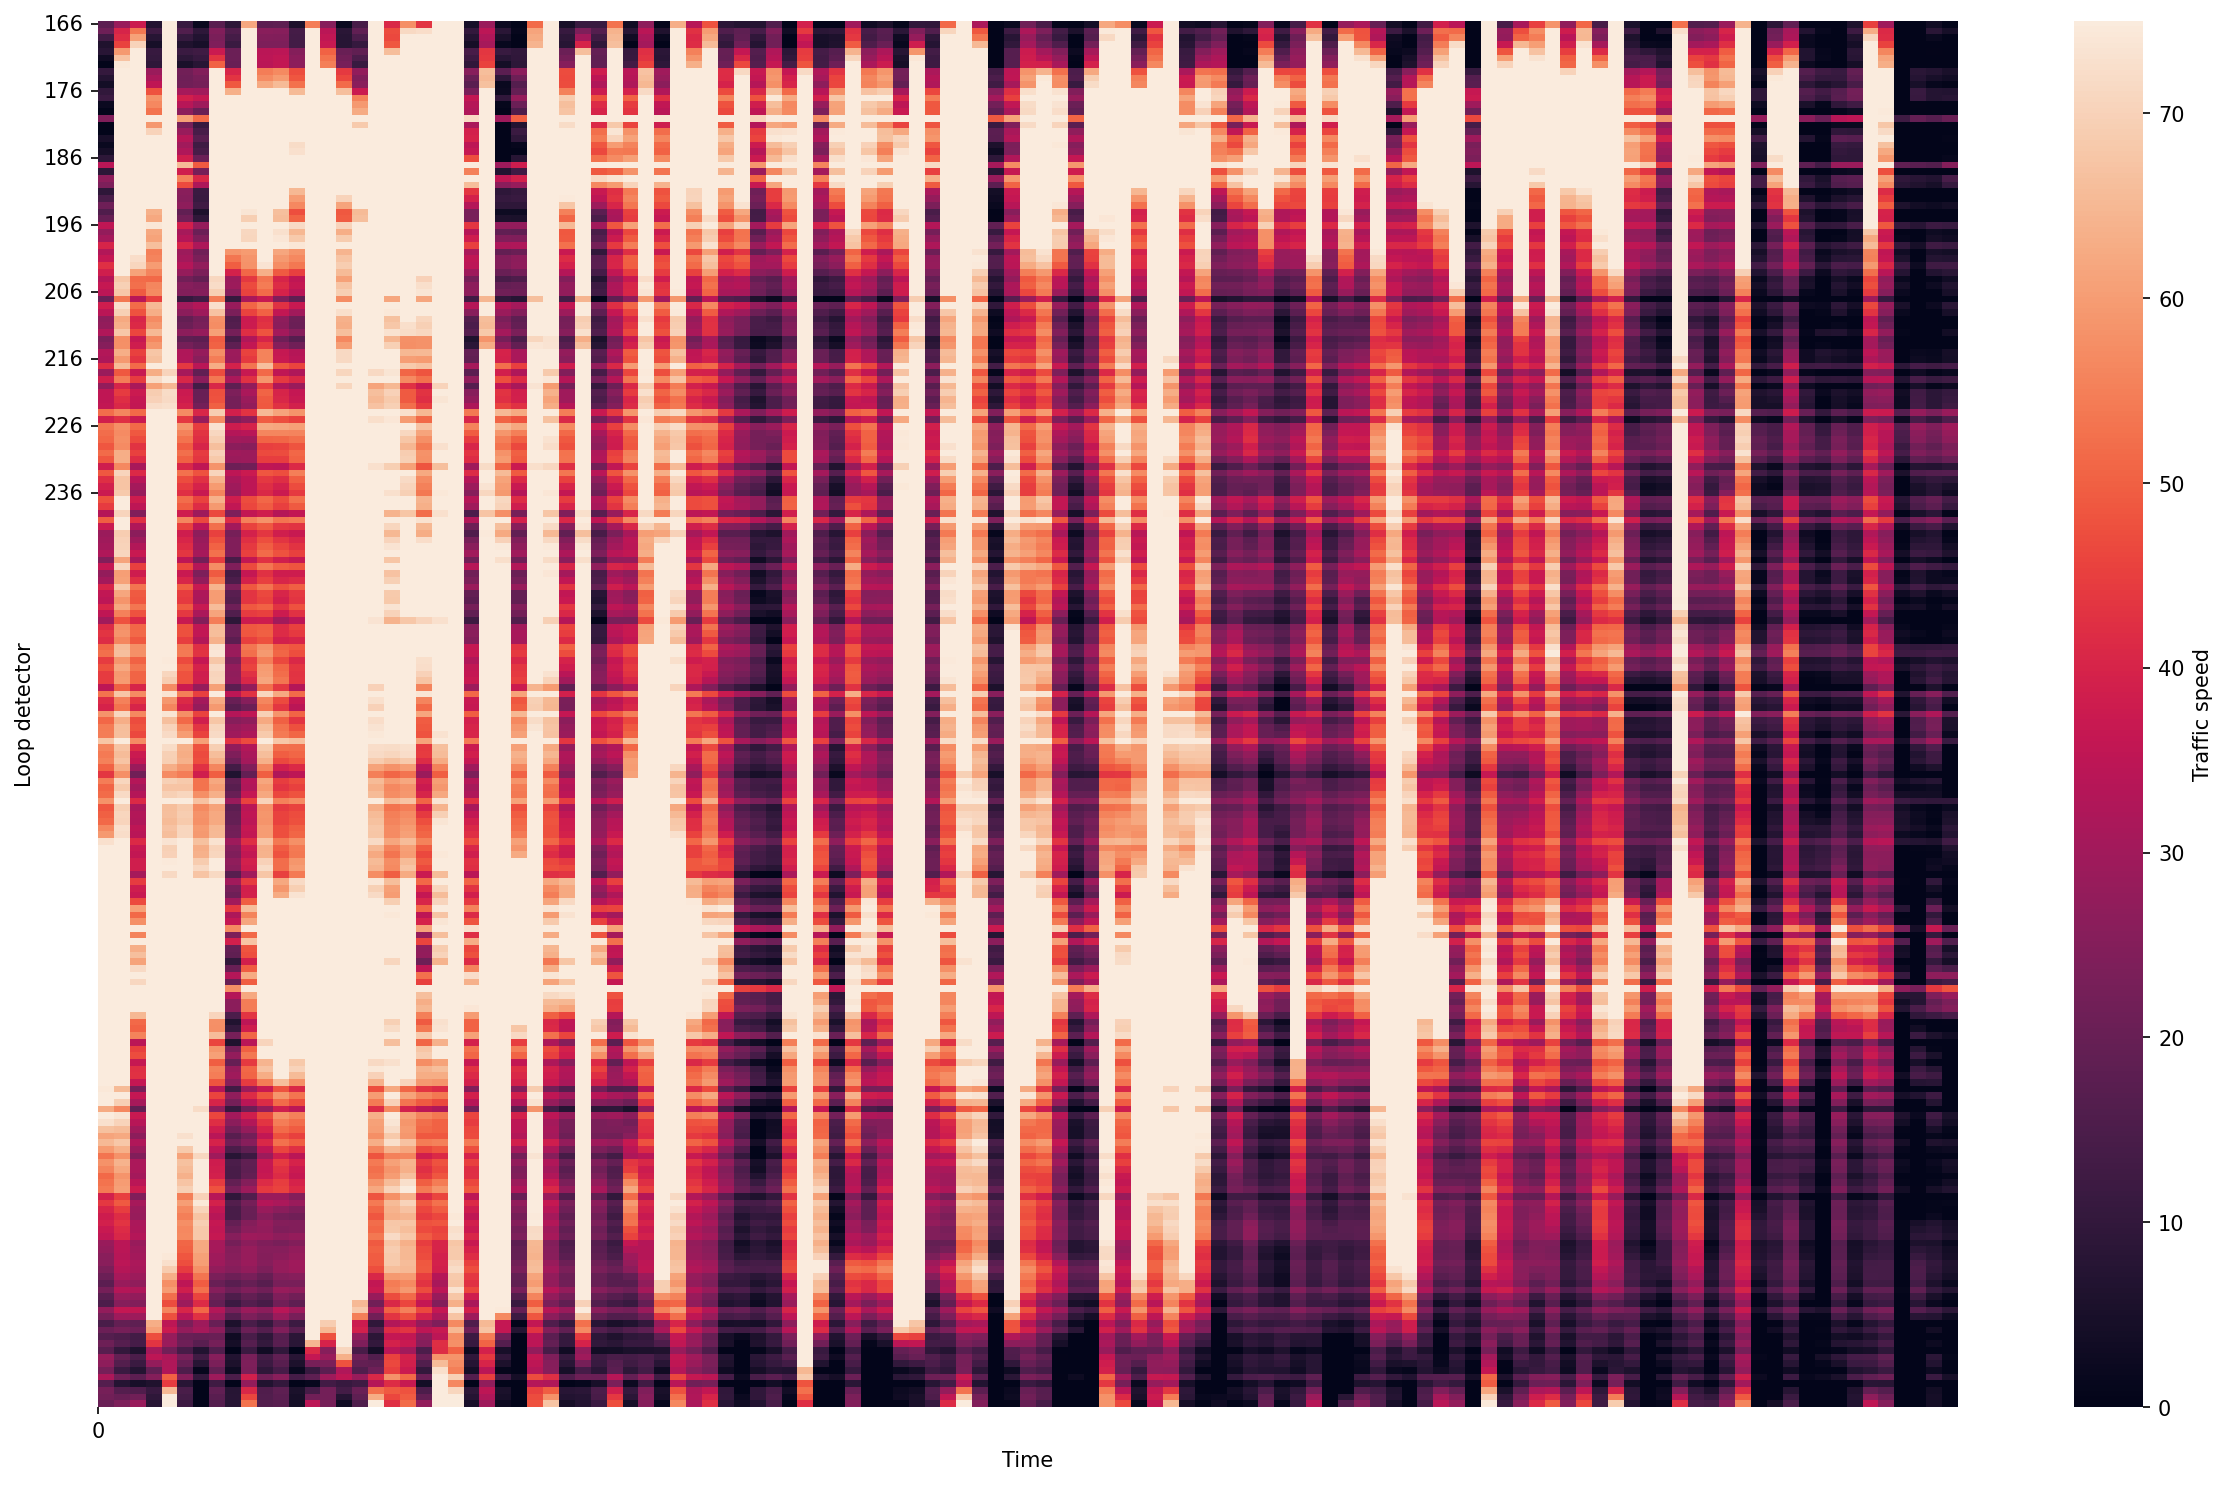

In [654]:
import time
start = time.time()
N, T = sparse_mat.shape
lmbda = 1e-5 * N * T
gamma = 1 * lmbda
tau_s = 1
tau = 5
maxiter = 150


mat_hat = LCR_2d(dense_mat, sparse_mat, lmbda, gamma, tau_s, tau, maxiter)
end = time.time()
print('Running time: %d seconds.'%(end - start))


fig = plt.figure(figsize = (20, 12), dpi=150)
sns.heatmap(mat_hat, cbar_kws={'label': 'Traffic speed'}, vmin = 0, vmax = 75)
plt.xticks(np.arange(0, 117, 250), np.arange(0, 117, 250), rotation = 0)
plt.yticks(np.arange(0.5, 75.5, 10), np.arange(166, 241, 10), rotation = 0)
plt.xlabel('Time')
plt.ylabel('Loop detector')
plt.show()

In [655]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

读取邻接矩阵

In [656]:
import pandas as pd
df_adj = pd.read_csv('adj.csv', encoding='unicode_escape')
df_adj = np.array(df_adj)
df_adj.shape
df_adj

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

  构建OD矩阵

In [657]:
station_str = '福田	益田	布心	车公庙	五和	科学馆	燕南	景田	香梅北	坂田	竹子林	莲花北	田贝	深圳北	大剧院	老街	华强路	清湖	白石洲	大新	坪洲	双龙	布吉	华侨城	福田口岸	华强北	市民中心	福民	丹竹头	红岭	桃园	侨城北	南联	通新岭	翠竹	国贸	黄贝岭	怡景	后瑞	莲花村	东角头	湾厦	百鸽笼	侨城东	罗湖	后海	登良	翻身	侨香	海月	购物公园	世界之窗	科苑	草埔	龙华	灵芝	蛇口港	华新	晒布	石厦	太安	红树湾	新秀	西丽	大芬	高新园	岗厦	民治	深圳大学	湖贝	荷坳	岗厦北	莲花西	红山	新安	兴东	下水径	水湾	上塘	大运	上梅林	少年宫	会展中心	宝安中心	洪浪北	白石龙	宝华	横岗	西乡	民乐	龙城广场	木棉湾	六约	爱联	宝体	龙胜	水贝	香蜜	留仙洞	机场东	大学城	永湖	吉祥	长龙	安托山	上水径	固戍	长岭陂	赤湾	海上世界	塘朗	杨美	塘坑	前海湾	深康	鲤鱼门	临海'
stations = station_str.split()
# stations

In [658]:
 #读取流量数据
import pandas as pd
df = pd.read_csv('SmartCardData.txt', sep=',', header=None)

In [659]:
#筛选地铁数据
df = df[(df[2] < 31) & (df[3] != 'None')]
df = df.sort_values(by = [0, 1, 2],axis = 0,ascending = True)
df

,0,1,2,3
3,1,07:41:21,21,益田
2,1,07:54:42,22,福田
1,1,21:41:35,21,福田
0,1,21:53:31,22,益田
7,3,08:14:23,21,布心
...,...,...,...,...
7532467,2537257,17:32:08,21,深圳北
7532478,2537258,08:41:26,21,世界之窗
7532472,2537258,08:52:29,22,深圳大学
7532471,2537258,15:48:38,21,侨城东


In [660]:
#重置索引
df = df.reset_index(drop=True)
df

,0,1,2,3
0,1,07:41:21,21,益田
1,1,07:54:42,22,福田
2,1,21:41:35,21,福田
3,1,21:53:31,22,益田
4,3,08:14:23,21,布心
...,...,...,...,...
3242246,2537257,17:32:08,21,深圳北
3242247,2537258,08:41:26,21,世界之窗
3242248,2537258,08:52:29,22,深圳大学
3242249,2537258,15:48:38,21,侨城东


In [661]:
t = df[1].max().split(':')
index = int(t[0])*12 + int(t[1]) // 5
index

287

In [662]:
#根据源数据统计流量矩阵
i = 0
dic = {}
while i < len(df) - 1:
    if df[0].iloc[i] == df[0].iloc[i+1]:
        if df[2].iloc[i] == 21 and df[2].iloc[i+1] == 22:
            if df[3].iloc[i] in stations and df[3].iloc[i+1] in stations:
                #时间节点，划分为288维
                t = df[1].iloc[i].split(':')
                index = int(t[0])*12 + int(t[1]) // 5

                name = df[3].iloc[i] + '_' + df[3].iloc[i+1] + '_' + str(index)
                
                if name in dic:
                    dic[name] += 1
                else:
                    dic[name] = 1
            i += 2
        else:
            # print(df.iloc[i-2:i+3])
            i += 1
    else:
        i += 1

    # if i % 10000 == 1:
    #     print(i)

切时间片代码 288维度

In [663]:
# import numpy as np
# #流量矩阵形成
# OD_matrix = np.zeros((288, 117, 117))
# OD_weight_time = np.zeros((288, 117, 117))

# #读取字典数据，构建站间流量矩阵
# for key in dic:
#     sta = key.split('_')[0]
#     end = key.split('_')[1]
#     tim = int(key.split('_')[-1])

#     i = stations.index(sta)
#     j = stations.index(end)
#     if i == j:
#         OD_matrix[tim][i][j] = 0
#     else:
#         OD_matrix[tim][i][j] = dic[key]

# #weight
# for t in range(OD_matrix.shape[0]):
#     for i in range(OD_matrix.shape[1]):
#         for j in range(OD_matrix.shape[2]):
#             #将无流量的值权重默认置0
#             if sum(OD_matrix[t][i][:]) == 0:
#                 left = 0.01
#             else:
#                 left = OD_matrix[t][i][j] / sum(OD_matrix[t][i][:]) 

#             if sum(OD_matrix[t][i][:]) == 0:
#                 right = 0.01
#             else:
#                 right = OD_matrix[t][i][j] / sum(OD_matrix[t][:][j])
#             #论文计算公式
#             res = (left + right) / 2
#             if res == float('inf') or str(res) == 'nan':
#                 OD_weight_time[t][i][j] = 0.01
#             else:
#                 OD_weight_time[t][i][j] = res
            # if i == j:
            #     OD_weight[t][i][j] = 0
# fig = plt.figure(figsize = (20, 12), dpi=150)
#可视化流量矩阵
# sns.heatmap(OD_matrix,  vmin = 0, vmax = 100)
# plt.xticks(np.arange(0, 117), stations, rotation = 0)


In [664]:
#讲OD矩阵作为每个站点的权重和原始矩阵做点乘，从而优化原始矩阵
#以时间片维度依次乘相应时间的权重
# dense_OD_mat = []
# dense_OD_mat = np.zeros((207, 117))
# for i in range(207):
#     dense_OD_mat[i] = np.dot(dense_mat[i], OD_weight_time[i+80])
# dense_OD_mat_ = np.array(dense_OD_mat)
# dense_OD_mat_.shape

In [665]:
import numpy as np
#流量矩阵形成
OD_matrix = np.zeros((117, 117))
OD_weight = np.zeros((117, 117))

#读取字典数据，构建站间流量矩阵
for key in dic:
    sta = key.split('_')[0]
    end = key.split('_')[1]
    i = stations.index(sta)
    j = stations.index(end)
    if i == j:
        OD_matrix[i][j] = 0
    else:
        OD_matrix[i][j] = dic[key]

#weight
for i in range(OD_matrix.shape[0]):
    for j in range(OD_matrix.shape[1]):
        #论文计算公式
        OD_weight[i][j] = (OD_matrix[i][j] / sum(OD_matrix[i][:]) + OD_matrix[i][j] / sum(OD_matrix[:][j])) / 2  
        if i == j:
            OD_weight[i][j] = 0
            
        # if OD_matrix[i][j] == 0:
        #     OD_weight[i][j] = 0

fig = plt.figure(figsize = (20, 12), dpi=150)


<Figure size 3000x1800 with 0 Axes>

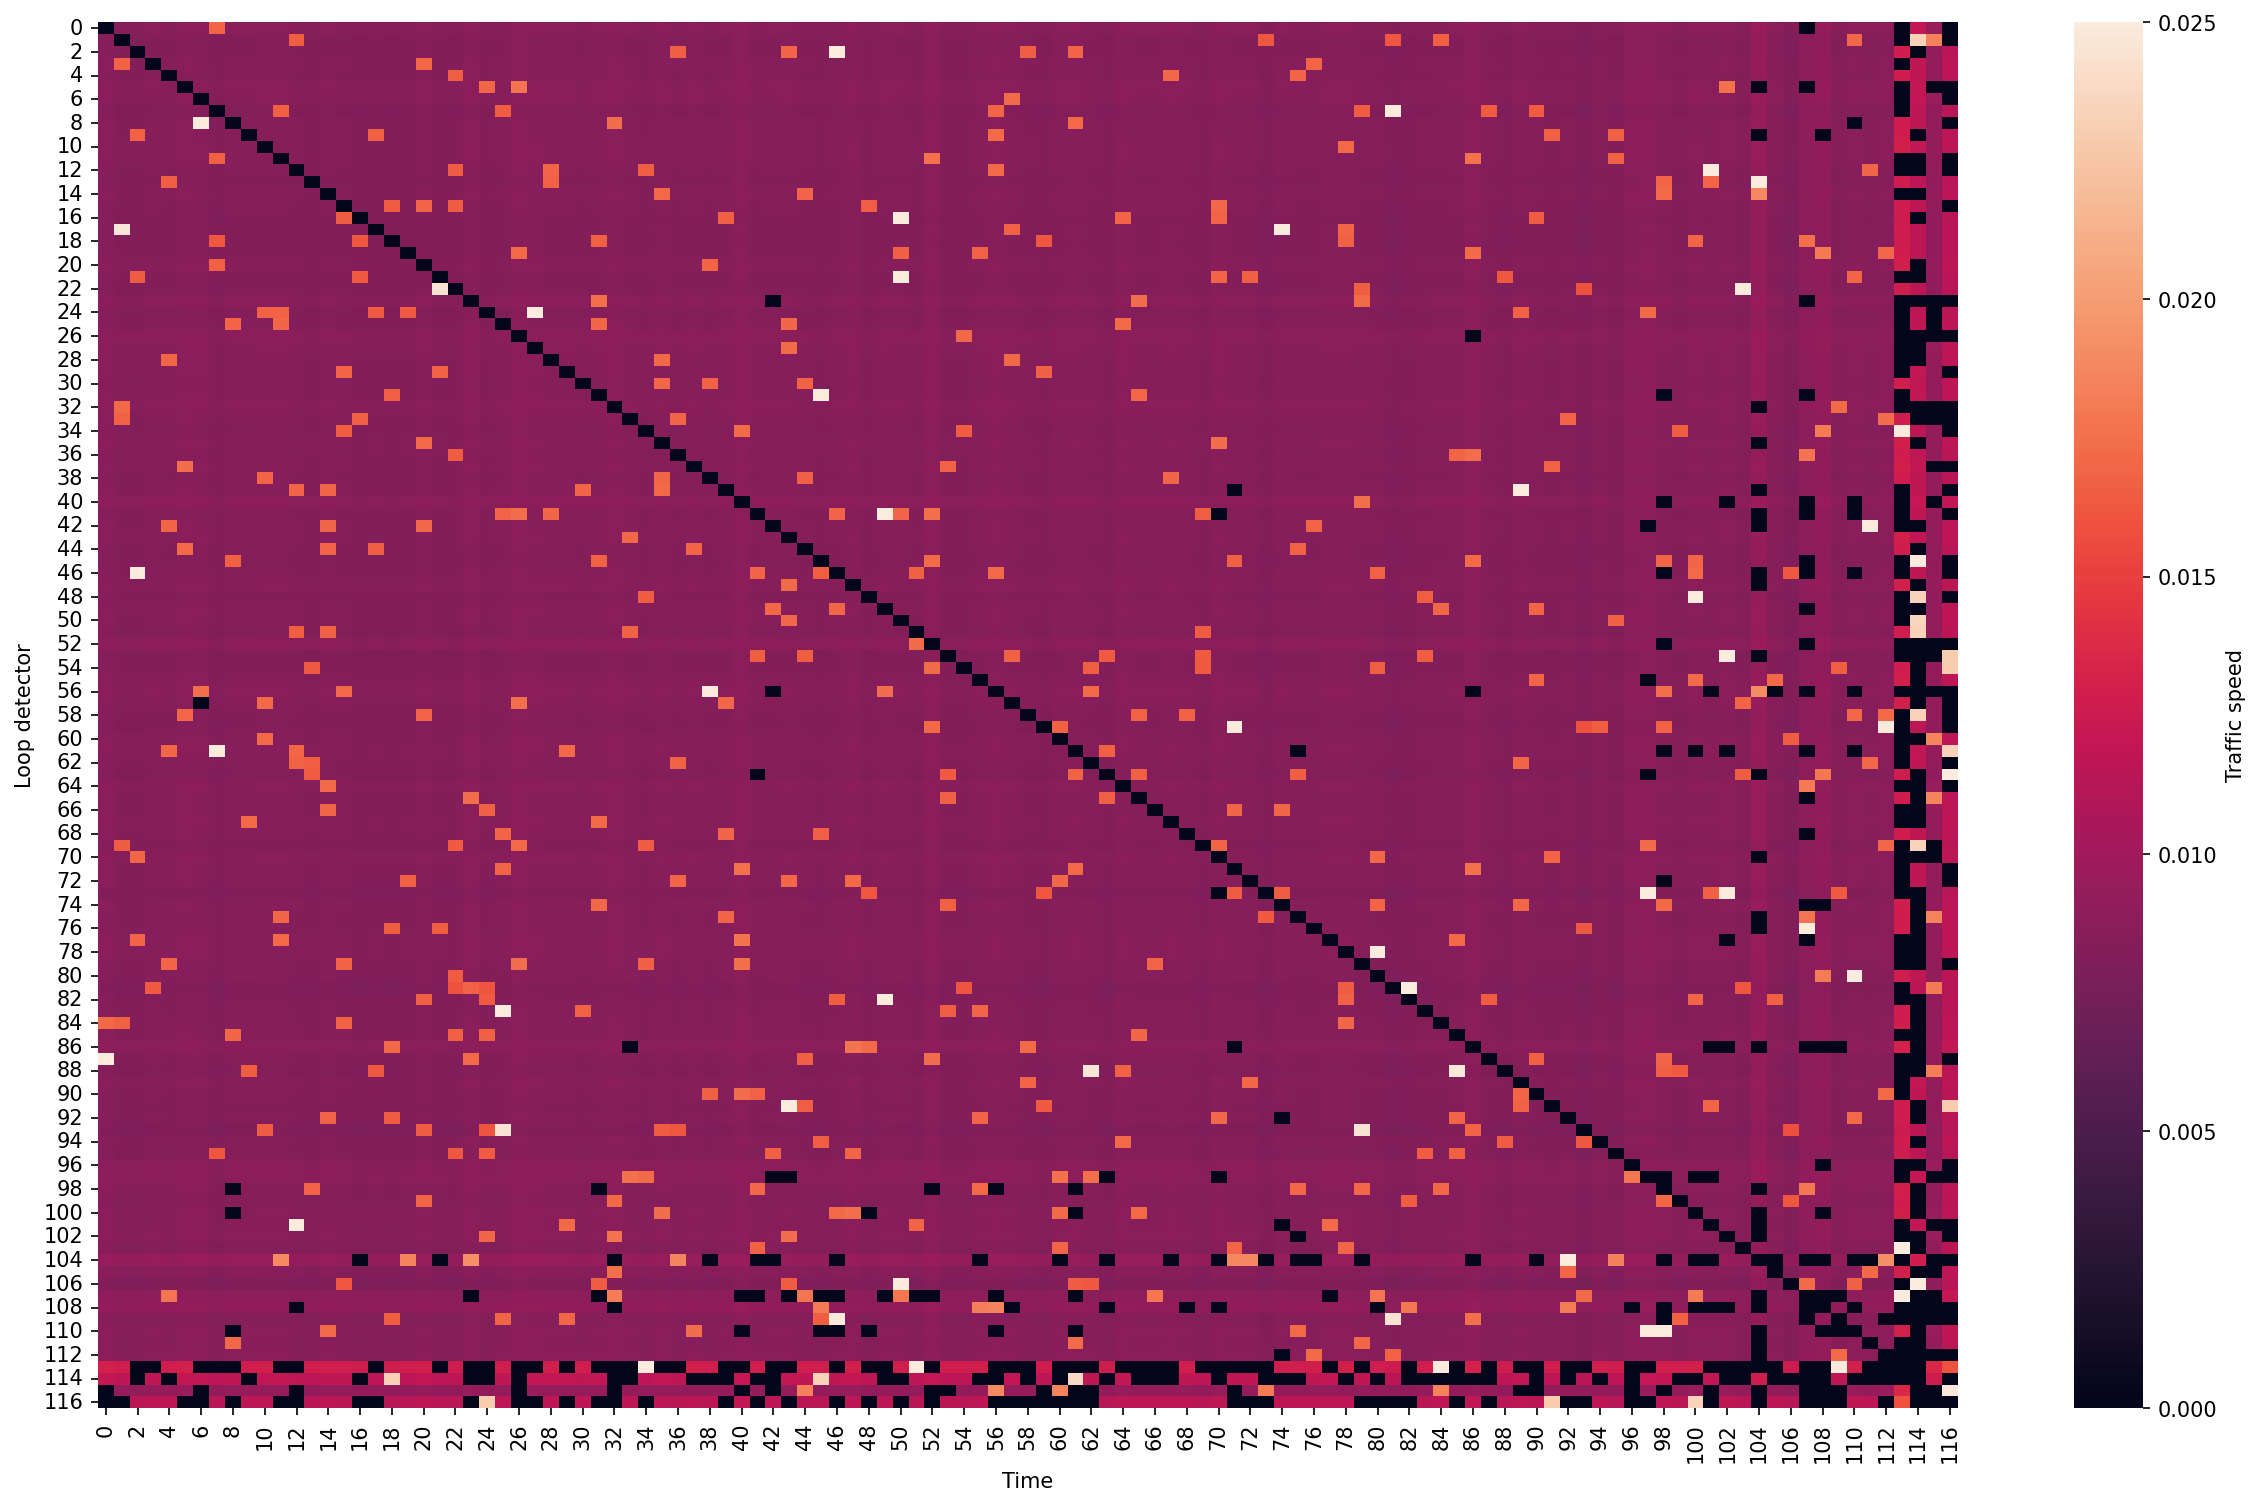

In [666]:
#可视化OD矩阵
fig = plt.figure(figsize = (20, 12), dpi=150)
sns.heatmap(OD_weight, cbar_kws={'label': 'Traffic speed'}, vmin = 0, vmax = 0.025)
# plt.xticks(np.arange(0, 117, 250), np.arange(0, 117, 250), rotation = 0)
# plt.yticks(np.arange(0.5, 75.5, 10), np.arange(166, 241, 10), rotation = 0)
plt.xlabel('Time')
plt.ylabel('Loop detector')
plt.show()

In [667]:
#讲OD矩阵作为每个站点的权重和原始矩阵做点乘，从而优化原始矩阵
# OD_weight = standardization(OD_weight)
def weight(dense_mat):
    dense_OD_mat_ = np.dot(dense_mat, OD_weight)
    for i in range(dense_mat.shape[0]):
        for j in range(dense_mat.shape[1]):
            if dense_mat[i][j] == 0:
                dense_OD_mat_[i][j] = dense_mat[i][j]

    return dense_OD_mat_

dense_OD_mat_ = weight(dense_mat)

In [668]:
# import numpy as np
# bais = np.round(np.random.rand(1, dense_OD_mat_.shape[0])[:, :, np.newaxis] + 0.5 - missing_rate)
# bais = np.save('array_bais_1.npy', bais)
# OD_weight


In [669]:
# bais = np.round(np.random.rand(1, dense_OD_mat_.shape[0])[:, :, np.newaxis] + 0.5 - missing_rate)
# bais = np.load('array_bais.npy')
# OD_sparse = dense_OD_mat_ * bais
# OD_sparse_mat = OD_sparse.reshape([dense_OD_mat_.shape[0] , dense_OD_mat_.shape[1]])

def LCR_2d(y_true, y, lmbda, gamma, tau_s=1, tau=5, maxiter = 50):
    eta = 100 * lmbda
    N, T = y.shape
    pos_train = np.where(y != 0)
    print(y.shape)
    #挑选y中不等于0的值
    y_train = y[pos_train]
    #挑选y_true不等于0的值，但y等于0的值，测试集
    pos_test = np.where((y_true != 0) & (y == 0))
    y_test = y_true[pos_test]
    z = y.copy()
    w = y.copy()
    
    #N,T分别为长宽
    ell_s = laplacian(N, tau_s)
    ell_t = laplacian(T, tau)
    #np.outer计算外积，变成一个N*T的矩阵，np.fft.fft2（傅立叶变换）
    # print(np.fft.fft2(np.outer(ell_s, ell_t)) )
    denominator = lmbda + gamma * np.fft.fft2(np.outer(ell_s, ell_t)) ** 2
    
    del y_true, y
    show_iter = 4
    for it in range(maxiter):
        x = prox_2d(z, w, lmbda, denominator)
        #OD矩阵权重结合到算法运算中
        z = weight(update_z(y_train, pos_train, x, w, lmbda, eta))
        w = weight(update_w(x, z, w, lmbda))        
        if (it + 1) % show_iter == 0:
            print(it + 1)
            print("mape", compute_mape(y_test, x[pos_test]))
            print("rmse", compute_rmse(y_test, x[pos_test]))
            print()
    return x

N, T = dense_OD_mat_.shape
lmbda = 1e-5 * N * T
gamma = 5 * lmbda
tau_s = 1
tau = 5
maxiter = 25
mat_hat = LCR_2d(dense_OD_mat_, sparse_mat, lmbda, gamma, tau_s, tau, maxiter)




(207, 117)
4
mape 0.9683482288679148
rmse 62.35145530346492

8
mape 1.2364027828738806
rmse 32.38823022258228

12
mape 0.7841950208812151
rmse 22.073002108627765

16
mape 0.6181956829739049
rmse 19.49208334503479

20
mape 0.47244131308771853
rmse 17.82434269666594

24
mape 0.47565018825031635
rmse 16.728799169757544



In [670]:

# bais = np.round(np.random.rand(1, dense_OD_mat_.shape[0])[:, :, np.newaxis] + 0.5 - missing_rate)
# bais = np.load('array_bais.npy')
# OD_sparse = np.dot(sparse_mat, OD_weight)
# OD_sparse_mat = OD_sparse.reshape([dense_OD_mat_.shape[0] , dense_OD_mat_.shape[1]])

N, T = sparse_mat.shape
lmbda = 1e-5 * N * T
gamma = 1 * lmbda
tau_s = 1
tau = 5
maxiter = 150

# dense_OD_mat_ = np.dot(dense_mat, OD_weight)

mat_hat = LCR_2d(dense_OD_mat_, sparse_mat, lmbda, gamma, tau_s, tau, maxiter)



(207, 117)
4
mape 0.9683480883781
rmse 62.351450016413295

8
mape 1.2364028824370263
rmse 32.38822993417877

12
mape 0.78419493973583
rmse 22.073001330274924

16
mape 0.6181956239760825
rmse 19.492082483149133

20
mape 0.47244124233144486
rmse 17.824341225135708

24
mape 0.4756501535214802
rmse 16.728798038994576

28
mape 0.5196056474801893
rmse 17.005702945712617

32
mape 0.5454440192093111
rmse 17.73814171573085

36
mape 0.5572645599349352
rmse 18.07638855511212

40
mape 0.575980433380301
rmse 18.189408129066948

44
mape 0.5914181929642959
rmse 18.13552324088437

48
mape 0.5937123336246746
rmse 18.06649044541644

52
mape 0.5848247216903703
rmse 18.082236846789602

56
mape 0.5742522177395682
rmse 18.14979667863481

60
mape 0.568628331300829
rmse 18.235435240960456

64
mape 0.5687679153711852
rmse 18.325411749087525

68
mape 0.5721349115081314
rmse 18.408863334910816

72
mape 0.5761634468779884
rmse 18.47754964060853

76
mape 0.5788059078158877
rmse 18.536595060473392

80
mape 0.579538

实验代码，忽略

In [229]:
# #读取流量数据
# lines = open('SmartCardData.txt', 'r').read().splitlines()
# data_select = []
# #筛选数据
# for line in lines:
#     if line.split(',')[-1] in stations:
#         data_select.append(line)
# len(data_select)

# dic = {}
# i = 0
# while i < len(data_select) - 1:
#     start = data_select[i].split(',')[-1]
#     id_s = data_select[i].split(',')[0]
#     end = data_select[i+1].split(',')[-1]
#     id_e = data_select[i+1].split(',')[0]
#     i += 1
#     if id_s != id_e:
#         # print(i, data_select[i-3:i+2])
#         i += 1
#     else: 
#         name = start + '_' + end
#         if name in dic:
#             dic[name] += 1
#         else:
#             dic[name] = 1
# dic

In [4]:
# ss = np.round(np.random.rand(dim[0], dim[1])[:, :, np.newaxis] + 0.5 - missing_rate)
# # print()
# print(dense_tensor[0][1])

# sparse_tensor = dense_tensor * ss
# print(sparse_tensor[0][1])

In [35]:
pos_train = np.where(sparse_mat == 1)
y_train = sparse_mat[pos_train]
y_train.shape
# np.array(x).shape
# sparse_mat.shape

(103,)